Since we are only extrapolating on the time domain, we can drop S dependencies on all other variables, and let the PINN model learn them.

Hiroyasu & Arai: Two formulae as asymptotes, using fitted weights for their linear combinations.

$$
S(t) = w(t) \cdot k_v t
+ (1-w(t)) \cdot k_p  \sqrt{t}
$$

Here, we use:

$$
w(t) = \sigma (\frac{t_b-t}{s}) = \frac{1}{1+e^{\frac{t_b-t}{s}}}
$$

Fit: $$ t_b, s ,\ ln(k_v) ,\ ln(k_p) \ -> w(t), \ k_v, \ k_p $$

$$
\frac{d}{dt} w(t) = \frac{d}{dt}(1+e^{\frac{t_b-t}{s}})^{-1} = -(1+e^{\frac{t_b-t}{s}})^{-2} \cdot \frac{d}{dt} (e^{\frac{t_b-t}{s}}) = -(1+e^{\frac{t_b-t}{s}})^{-2} (-1/s) (e^{\frac{t_b-t}{s}})
$$


$$
\frac{d}{dt}w(t) = (1/s)(e^{\frac{t_b-t}{s}})(1+e^{\frac{t_b-t}{s}})^{-2}
$$

 $$

 \frac{d}{dt} (k_v w(t) t) = k_v w'(t) t + k_v w(t)
 $$

 $$
\frac{d}{dt} ( k_p w(t) \sqrt{t}) = k_v w'(t) t + k_v w(t)

 $$

In [1]:
import pandas as pd

df = pd.read_csv(r"D:\data\Nozzle1\Nozzle1_test_data.csv")

fps = 25000
# px_mm_scale = df["px2mm_scale"][0] #To be calibrated later
px_mm_scale = 0.24
hydraulic_delay = 16


dataset = "median" # or "median"
USE_STD_WEIGHTS = False

In [2]:
df.shape

(1350, 13)

In [ ]:
chunk_size = 50
num_chunks = (len(df) + chunk_size - 1) // chunk_size
chunk_indices = list(range(num_chunks))


27

In [4]:
example_chunk = 0
df_tp = df.iloc[example_chunk * chunk_size:(example_chunk + 1) * chunk_size].copy()


In [5]:
import numpy as np


def build_fit_arrays(df_tp):
    t = 1.0 / fps * (df_tp["frame_number"].to_numpy(dtype=float) - hydraulic_delay)

    if dataset == "median":
        y = px_mm_scale * df_tp["penetration_median"].to_numpy(dtype=float)
    elif dataset == "mean":
        y = px_mm_scale * df_tp["penetration_average"].to_numpy(dtype=float)
    else:
        raise ValueError(f"Unknown dataset: {dataset}")

    if "penetration_std" in df_tp.columns and USE_STD_WEIGHTS:
        sigma = df_tp["penetration_std"].to_numpy(dtype=float)
        sigma = np.where(
            np.isfinite(sigma) & (sigma > 1e-9),
            sigma,
            np.nanmedian(sigma[np.isfinite(sigma) & (sigma > 0)])
        )
    else:
        sigma = np.ones_like(y)

    return t, y, sigma


In [6]:
import numpy as np
from scipy.special import expit  # expit(x) = 1 / (1 + exp(-x))

# If you used a lower bound on tb before, keep it here
min_tb = 0.0  # change if you want a strictly positive minimum break time


def spray_penetration_model_sigmoid(params, t):
    """
    params (log-space): [log_c_lin, log_c_sqrt, log_tb, log_s]
        - c_lin  : effective linear-region gain (kv * sqrt(2*delta_p/rho_f))
        - c_sqrt : effective sqrt-region gain (kp * (delta_p/rho_a)**0.25 * sqrt(d))
        - tb     : break time (with lower bound min_tb)
        - s      : transition softness of the sigmoid

    t: array-like or float (time)
    """
    log_c_lin, log_c_sqrt, log_tb, log_s = params

    c_lin = np.exp(log_c_lin)
    c_sqrt = np.exp(log_c_sqrt)
    tb = np.exp(log_tb) + min_tb
    s = np.exp(log_s)

    # numerical guard
    t = np.clip(t, 1e-9, None)

    # Linear and sqrt asymptotes
    linear = c_lin * t
    sqrt_segment = c_sqrt * np.sqrt(t)

    # Sigmoid weight from sqrt side; (1-w) weights the linear side
    w = expit((t - tb) / s)

    return (1.0 - w) * linear + w * sqrt_segment


In [7]:
from scipy.optimize import least_squares

init = {
    "kv": 1.0,
    "kp": 1.0,
    "tb": 1e-1,
    "s": 1.0,
}
x0 = np.log([init["kv"], init["kp"], init["tb"], init["s"]])


def fit_sigmoid(df_tp, return_arrays=False):
    t, y, sigma = build_fit_arrays(df_tp)

    valid = np.isfinite(t) & np.isfinite(y) & np.isfinite(sigma) & (sigma > 0)
    if not np.any(valid):
        result = {
            "log_params": np.full(4, np.nan),
            "kv": np.nan,
            "kp": np.nan,
            "tb": np.nan,
            "s": np.nan,
            "cost": np.inf,
            "success": False,
            "n": 0,
        }
        if return_arrays:
            result["t"] = t
            result["y"] = y
            result["sigma"] = sigma
        return result

    def residuals(params):
        t_fit = t[valid]
        y_fit = y[valid]
        sigma_fit = sigma[valid]

        y_hat = spray_penetration_model_sigmoid(params, t_fit)
        return (y_hat - y_fit) / sigma_fit

    res = least_squares(residuals, x0, method="trf", loss="huber", f_scale=1.0)

    log_kv, log_kp, log_tb, log_s = res.x
    result = {
        "log_params": res.x,
        "kv": float(np.exp(log_kv)),
        "kp": float(np.exp(log_kp)),
        "tb": float(np.exp(log_tb) + min_tb),
        "s": float(np.exp(log_s)),
        "cost": float(res.cost),
        "success": bool(res.success),
        "n": int(valid.sum()),
    }

    if return_arrays:
        result["t"] = t
        result["y"] = y
        result["sigma"] = sigma

    return result


In [8]:
results = []

for chunk_idx in chunk_indices:
    start = chunk_idx * chunk_size
    df_tp_chunk = df.iloc[start:start + chunk_size]
    if df_tp_chunk.empty:
        continue

    fit = fit_sigmoid(df_tp_chunk)
    fit["chunk_idx"] = chunk_idx
    fit["start_row"] = start
    fit["end_row"] = start + len(df_tp_chunk) - 1
    results.append(fit)

fit_results = pd.DataFrame(results)

if fit_results.empty:
    print("No chunks to fit.")
else:
    print(f"Fit done for {len(fit_results)} chunks.")
    print(f"Success rate: {fit_results['success'].mean():.3f}")

fit_results.head()

example_fit = fit_sigmoid(df_tp, return_arrays=True)
log_kv, log_kp, log_tb, log_s = example_fit["log_params"]
kv = example_fit["kv"]
kp = example_fit["kp"]
tb = example_fit["tb"]
s = example_fit["s"]

print("Example fit (chunk", example_chunk, ")")
print(f"kv={kv:.6g}, kp={kp:.6g}, tb={1e3*tb:.3g} ms, s={s:.6g}")
print("cost:", example_fit["cost"], "success:", example_fit["success"])


Fit done for 27 chunks.
Success rate: 0.963
Example fit (chunk 0 )
kv=0.019325, kp=2956.58, tb=0.103 ms, s=0.000137956
cost: 21.29101042832358 success: True


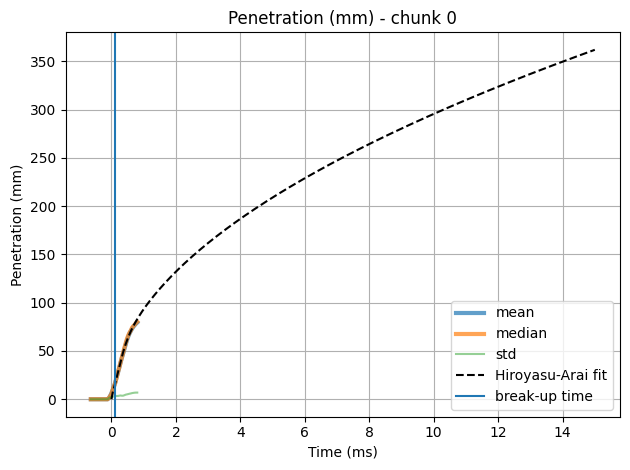

In [9]:
import matplotlib.pyplot as plt

frames = 125
frame_n = np.linspace(0, frames, frames + 1)
t_s = 1 / fps * frame_n

t_ms = 1e3 / fps * (df_tp["frame_number"] - hydraulic_delay)
t_ms_np = t_ms.to_numpy(dtype=float)

triple_ts = np.linspace(t_s[0], 3 * t_s[-1], 3 * len(t_s))


plt.plot(
    t_ms_np,
    px_mm_scale * df_tp["penetration_average"],
    label="mean",
    linewidth=3,
    alpha=0.7
)
plt.plot(
    t_ms_np,
    px_mm_scale * df_tp["penetration_median"],
    label="median",
    linewidth=3,
    alpha=0.7
)
plt.plot(
    t_ms_np,
    px_mm_scale * df_tp["penetration_std"],
    label="std",
    alpha=0.5
)

# Plot fitted curve using seconds (model expects SI units), x-axis stays in ms.
plt.plot(
    triple_ts * 1e3,
    spray_penetration_model_sigmoid([log_kv, log_kp, log_tb, log_s], triple_ts),
    "k--",
    linewidth=1.5,
    label="Hiroyasu-Arai fit"
)


plt.xlabel("Time (ms)")
plt.ylabel("Penetration (mm)")
plt.title(f"Penetration (mm) - chunk {example_chunk}")
plt.axvline(1e3 * tb, label="break-up time")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
t_s

array([0.00e+00, 4.00e-05, 8.00e-05, 1.20e-04, 1.60e-04, 2.00e-04,
       2.40e-04, 2.80e-04, 3.20e-04, 3.60e-04, 4.00e-04, 4.40e-04,
       4.80e-04, 5.20e-04, 5.60e-04, 6.00e-04, 6.40e-04, 6.80e-04,
       7.20e-04, 7.60e-04, 8.00e-04, 8.40e-04, 8.80e-04, 9.20e-04,
       9.60e-04, 1.00e-03, 1.04e-03, 1.08e-03, 1.12e-03, 1.16e-03,
       1.20e-03, 1.24e-03, 1.28e-03, 1.32e-03, 1.36e-03, 1.40e-03,
       1.44e-03, 1.48e-03, 1.52e-03, 1.56e-03, 1.60e-03, 1.64e-03,
       1.68e-03, 1.72e-03, 1.76e-03, 1.80e-03, 1.84e-03, 1.88e-03,
       1.92e-03, 1.96e-03, 2.00e-03, 2.04e-03, 2.08e-03, 2.12e-03,
       2.16e-03, 2.20e-03, 2.24e-03, 2.28e-03, 2.32e-03, 2.36e-03,
       2.40e-03, 2.44e-03, 2.48e-03, 2.52e-03, 2.56e-03, 2.60e-03,
       2.64e-03, 2.68e-03, 2.72e-03, 2.76e-03, 2.80e-03, 2.84e-03,
       2.88e-03, 2.92e-03, 2.96e-03, 3.00e-03, 3.04e-03, 3.08e-03,
       3.12e-03, 3.16e-03, 3.20e-03, 3.24e-03, 3.28e-03, 3.32e-03,
       3.36e-03, 3.40e-03, 3.44e-03, 3.48e-03, 3.52e-03, 3.56e

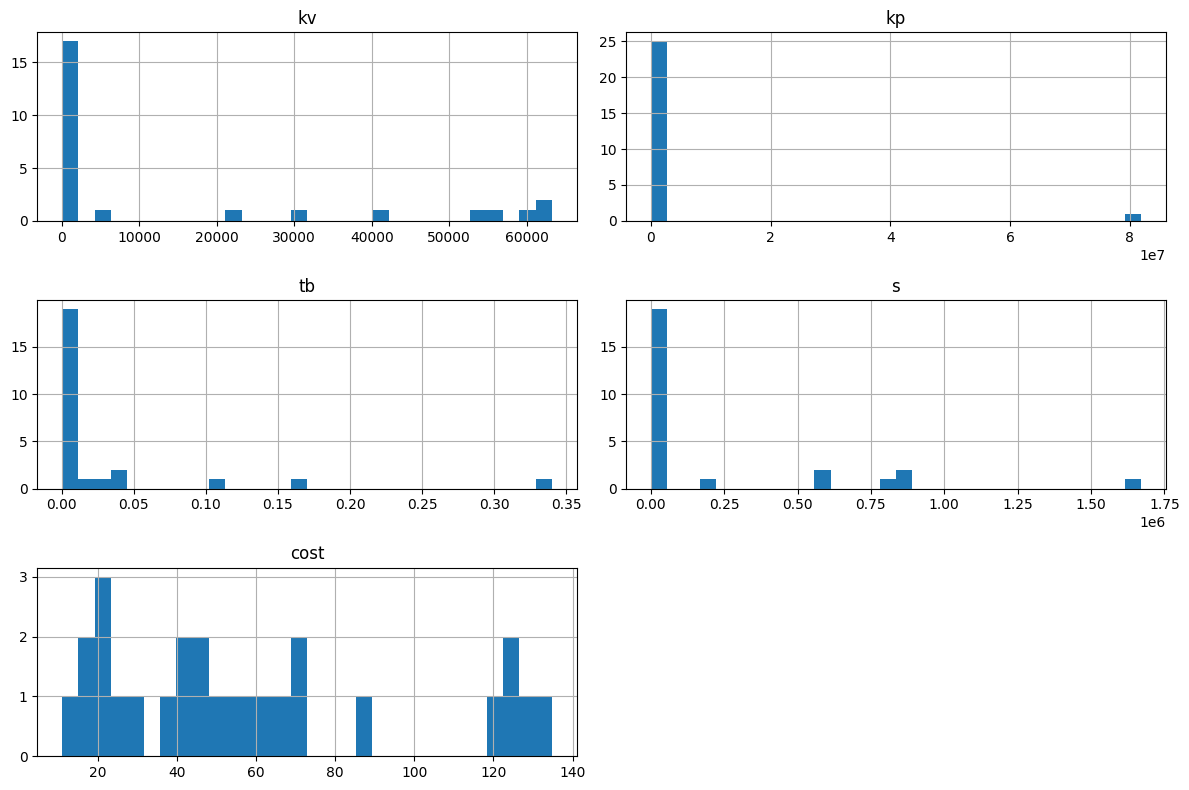

In [11]:
cols = ["kv", "kp", "tb", "s", "cost"]
fit_ok = fit_results[fit_results["success"]].copy()

if fit_ok.empty:
    print("No successful fits to summarize.")
else:
    fit_ok[cols].hist(bins=30, figsize=(12, 8))
    plt.tight_layout()
    plt.show()
    fit_ok[cols].describe()


Text(0, 0.5, 'tb Value (ms)')

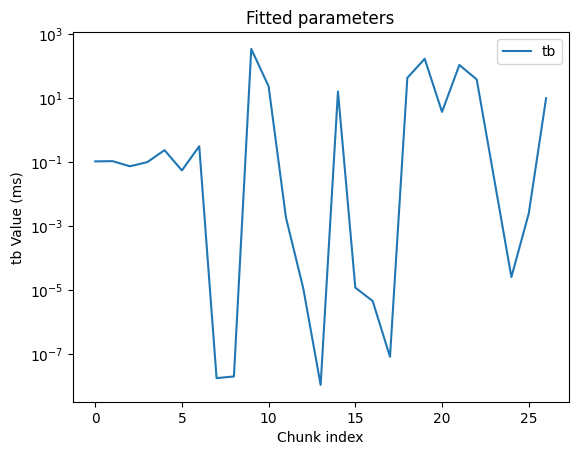

In [73]:
start = 0 
end = start + 27
# plt.plot(fit_ok["kv"][start:end], label="kv")
# plt.plot(fit_ok["kp"][start:end], label="kp")
plt.semilogy(1e3* fit_ok["tb"][start:end], label="tb")
# plt.semilogy(fit_ok["s"][start:end], label="s")
plt.legend()
plt.title("Fitted parameters")
plt.xlabel("Chunk index")
plt.ylabel("tb Value (ms)")

Text(0.5, 1.0, 'Fitted curves for Nozzle 1, test data (weighted medium pentration)')

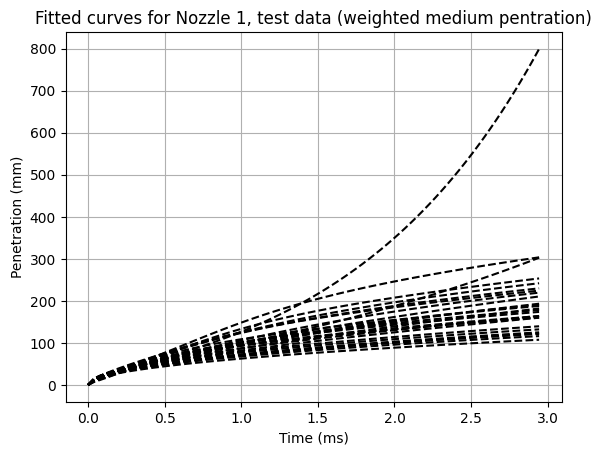

In [70]:
start = 0
end = start + 26
for i in range(start, end):
    log_kv = np.log(fit_ok["kv"].iloc[i])
    log_kp = np.log(fit_ok["kp"].iloc[i])
    log_tb = np.log(fit_ok["tb"].iloc[i] - min_tb)
    log_s = np.log(fit_ok["s"].iloc[i])
    # Plot fitted curve using seconds (model expects SI units), x-axis stays in ms.
    plt.plot(
        triple_ts[:len(triple_ts)//5] * 1e3,
        spray_penetration_model_sigmoid([log_kv, log_kp, log_tb, log_s],
                                         triple_ts)[:len(triple_ts)//5],
        "k--",
        linewidth=1.5,
        label="Hiroyasu-Arai fit"
    )
plt.xlabel("Time (ms)")
plt.ylabel("Penetration (mm)")
plt.grid()
plt.title("Fitted curves for Nozzle 1, test data (weighted medium pentration)")